Loaded 363069 images under train
Loaded 11932 images under val
Loaded 11965 images under test
Classes: 
['bar', 'line', 'pie']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


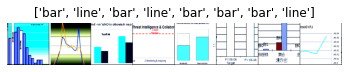

Test before training


C:\Users\matth\AppData\Local\Temp/ipykernel_9168/2846852384.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth:


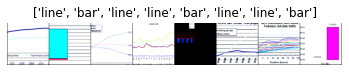

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:


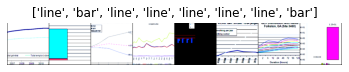

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth:


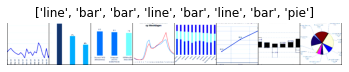

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:


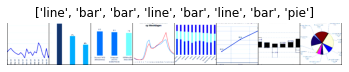

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth:


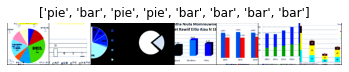

Prediction:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


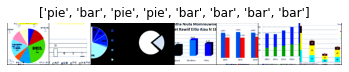

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth:


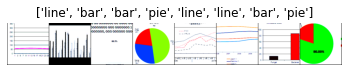

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:


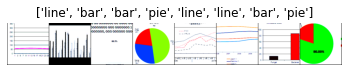

In [65]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
""""This file is to be used after you train your model in the ml_training file. It has the exact same
    initializations, as required to obstantiate the loaded .pt state_dict, you then can set the number
    of images in the visualize_model function. These images will be pulled from your test folder in a random order

    This file also uses CPU to do these predicitons, you will have to change the device settings if you wish to utilize your CUDA capable device"""
def main():
  pass

if __name__ == '__main__':


    # Loading this dataset with pytorch is really easy using ImageFolder
    # as the labels are specified by the folders names.
    # This folder path will be custom for each member
    data_dir = r'D:\School\SE\Group_Project\data'
    TRAIN = 'train'
    VAL = 'val'
    TEST = 'test'

    # VGG-16 Takes 224x224 images as input, so we resize all of them
    #it also takes normalization as specified at pytorch.com
    data_transforms = {
        TRAIN: transforms.Compose([
            # Data augmentation is a good practice for the train set
            # Here, we randomly crop the image to 224x224 and
            # randomly flip it horizontally (seems like best fit for graphs?)
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]),
        VAL: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]),
        TEST: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    }

    #creating our data set
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x),
            transform=data_transforms[x]
        )
        for x in [TRAIN, VAL, TEST]
    }

    #low batch sizes allow for our computers to compute these predicitions as they don't use much
    #video memory
    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size=8,
            shuffle=True, num_workers=4
        )
        for x in [TRAIN, VAL, TEST]
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

    for x in [TRAIN, VAL, TEST]:
        print("Loaded {} images under {}".format(dataset_sizes[x], x))


    print("Classes: ")
    class_names = image_datasets[TRAIN].classes
    print(image_datasets[TRAIN].classes)

    
    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        plt.axis('off')
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)
    
    
    
    def show_databatch(inputs, classes):
        out = torchvision.utils.make_grid(inputs)
        imshow(out, title=[class_names[x] for x in classes])
    
    
    inputs, classes = next(iter(dataloaders[TRAIN]))
    show_databatch(inputs, classes)
    
    #allows the integration of matplot lib to see some data
    def visualize_model(vgg, num_images=25):
        #was_training = vgg.training
    
        # Set model for evaluation
        #vgg.train(False)
        vgg.eval()
    
        images_so_far = 0
    
        for i, data in enumerate(dataloaders[TEST]):
            inputs, labels = data
            size = inputs.size()[0]
    

            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
    
            outputs = vgg(inputs)
    
            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]
    
            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)
    
            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()
    
            images_so_far += size
            if images_so_far >= num_images:
                break
    
        #vgg.train(mode=was_training)  # Revert model back to original training state

    
    
    #Load the pretrained model from pytorch
    vgg16 = models.vgg16_bn()

    
    # Freeze training for all layers
    for param in vgg16.features.parameters():
        param.require_grad = False
    
    # Newly created modules have require_grad=True by default
    num_features = vgg16.classifier[6].in_features
    features = list(vgg16.classifier.children())[:-1]  # Remove last layer
    features.extend([nn.Linear(num_features, len(class_names))])  # Add our layer with 4 outputs
    vgg16.classifier = nn.Sequential(*features)  # Replace the model classifier
    
    

    criterion = nn.CrossEntropyLoss()

    #optimization (possibly could use atom)
    optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    
    
    #load trained model
    vgg16.load_state_dict(torch.load(r"/Users/matthew/PycharmProjects/CSCI338_Project/VGG16_graphs.pt"))

    
    visualize_model(vgg16) #test after training


        
        